In [ ]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

### Create JNK artifact from JNK data "before handling missing"

In [ ]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from timecluster_extension.load import TSArtifact
import pickle
import matplotlib.pyplot as plt

#### Data Extraction

In [ ]:
base_path_jnk = Path.home()/'data/PACMEL-2019/JNK/' #*
data_file_name = 'jnk_before_handling_missing.pickle' #*

In [ ]:
# upload JNK data
f = open(f'{base_path_jnk}/{data_file_name}', 'rb')
bin_data = f.read()
jnk_file = pickle.loads(bin_data)
print(f'File uploaded successfully')

File uploaded successfully


In [ ]:
main_df = jnk_file[0]
main_df.index.freq = 's'
print(f'Num. variables: {len(main_df.columns)}')

Num. variables: 16


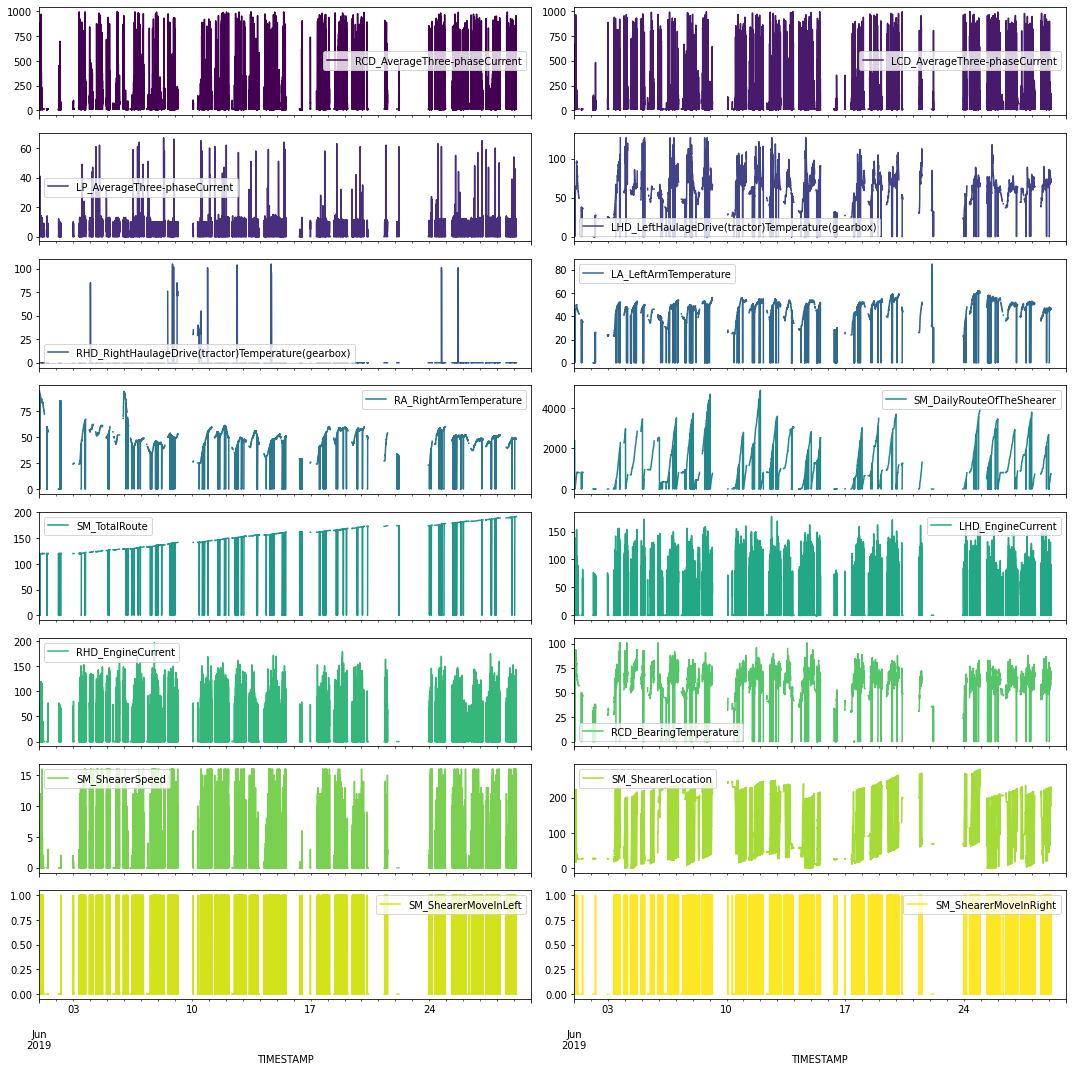

In [ ]:
main_df.plot(subplots=True,
             figsize=(15,15),
             layout=(8,2), 
             sharex=True,
             colormap='viridis')

plt.tight_layout()

#### Data Transformation

##### 1. Previous transformations
In this part, filters or transformation can be defined depending on variables origin or time-dependent features, among others.

In [ ]:
# variables types
variables_file_name = 'mining-mapping.csv' #*

var_df = pd.read_csv(f'{base_path_jnk}/{variables_file_name}', index_col='Variable name')
jnk_var_type = {var : var_df.loc[var,'Type'] for var in main_df.columns}
jnk_var_type

{'RCD_AverageThree-phaseCurrent': 'double',
 'LCD_AverageThree-phaseCurrent': 'double',
 'LP_AverageThree-phaseCurrent': 'double',
 'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)': 'double',
 'RHD_RightHaulageDrive(tractor)Temperature(gearbox)': 'double',
 'LA_LeftArmTemperature': 'double',
 'RA_RightArmTemperature': 'double',
 'SM_DailyRouteOfTheShearer': 'double',
 'SM_TotalRoute': 'double',
 'LHD_EngineCurrent': 'double',
 'RHD_EngineCurrent': 'double',
 'RCD_BearingTemperature': 'double',
 'SM_ShearerSpeed': 'double',
 'SM_ShearerLocation': 'double',
 'SM_ShearerMoveInLeft': 'bool',
 'SM_ShearerMoveInRight': 'bool'}

In [ ]:
# only double variables type are stored
double_var_list = [var for var, var_type in jnk_var_type.items() if var_type=='double']
df = main_df[main_df.columns.intersection(double_var_list)]
print(f'Num. variables: {len(df.columns)}')

Num. variables: 14


##### 2. Handle Missing Values, Resample and Normalize
In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied. This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

In [ ]:
wandb_artifacts_path = 'data/PACMEL-2019/wandb_artifacts' # When permissions are fixed, save artifacts in 'data/PACMEL-2019/wandb_artifacts'

In [ ]:
# training, validation and testing days
range_training = range(1, 16) #[15 days]
range_validation = range(16, 21) #[5 days]
range_testing = range(21, 30)  #[9 days]

# resampling frequency
resampling_freq = '5s'

# handle missing values technique
missing_values_technique='linear_interpolation'

In [ ]:
# Training data
df_training = df.query('index.dt.day.isin(@range_training)')
training_artifact = TSArtifact.from_df(df_training, 
                                       name='JNK', 
                                       missing_values_technique=missing_values_technique,
                                       resampling_freq=resampling_freq, 
                                       normalize=True, 
                                       path=str(Path.home()/wandb_artifacts_path))
training_artifact.metadata

{'TS': {'sd': '2019-06-01 00:00:00',
  'ed': '2019-06-15 23:59:59',
  'created': 'from-df',
  'n_vars': 14,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 259200,
  'freq': '<5 * Seconds>',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation'],
  'normalization': {'means': {'RCD_AverageThree-phaseCurrent': 39.716197145061734,
    'LCD_AverageThree-phaseCurrent': 38.54135300925926,
    'LP_AverageThree-phaseCurrent': 2.0873996913580246,
    'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)': 58.599024305555545,
    'RHD_Right

In [ ]:
# Validation data
df_validation = df.query('index.dt.day.isin(@range_validation)')
validation_artifact = TSArtifact.from_df(df_validation,
                                         name='JNK', 
                                         missing_values_technique=missing_values_technique,
                                         resampling_freq=resampling_freq, 
                                         normalize=False,
                                         path=str(Path.home()/wandb_artifacts_path))
validation_artifact.metadata

{'TS': {'sd': '2019-06-16 00:00:00',
  'ed': '2019-06-20 23:59:59',
  'created': 'from-df',
  'n_vars': 14,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 86400,
  'freq': '<5 * Seconds>',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation'],
  'hash': '2425531578650557693'}}

In [ ]:
# Testing data
df_testing = df.query('index.dt.day.isin(@range_testing)')
testing_artifact = TSArtifact.from_df(df_testing,
                                      name='JNK', 
                                      missing_values_technique=missing_values_technique,
                                      resampling_freq=resampling_freq, 
                                      normalize=False,
                                      path=str(Path.home()/wandb_artifacts_path))
testing_artifact.metadata

{'TS': {'sd': '2019-06-21 00:00:00',
  'ed': '2019-06-29 23:59:59',
  'created': 'from-df',
  'n_vars': 14,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 155520,
  'freq': '<5 * Seconds>',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation'],
  'hash': '4176464486517542438'}}

#### Data Loading

In [ ]:
# IMPORTANT! --> use wandb.init(..., mode='disabled', ...) to test W&B API
run = wandb.init(entity = 'pacmel', project='timecluster-extension', job_type='create_dataset', resume=True, mode='disabled')

In [ ]:
# log the artifacts
run.log_artifact(training_artifact)
run.log_artifact(validation_artifact)
run.log_artifact(testing_artifact)

In [ ]:
run.finish()